# Project1 - Crash Data Montgomery County, MD

By: Heidy Togliatti & Mathias Lund Ahrn


In this project we will explore vehicle crash data from Montgomery County in Maryland. The data is collected from the Automated Crash Report System of the Maryland State Police. 

#### Our goals
- Explore the relation between:
    - substance abuse, driver at fault
    - speed limit, vehicle model year

(We will primarily look at accidents related in different speed limits, what vehicle body type and model year)

### About the dataset
**Name**: Crash Reporting - Drivers Data

**State**: Maryland, MD

**County**: Montgomery

**Last updated**: October 10th 2019

**Date created**: Septemeber 19th 2017

**Dataset Owner**: MCG ESB Service

Data acquired October 15th 2019, hosted on [GitHub](https://raw.githubusercontent.com/CruddyShad0w/CST-383-CrashData/master/Crash_Reporting_-_Drivers_Data.csv) by [Kyle Hays](https://github.com/CruddyShad0w/CST-383-CrashData/).


In [1]:
# code in this cell from: 
# https://stackoverflow.com/questions/27934885/how-to-hide-code-from-cells-in-ipython-notebook-visualized-with-nbviewer
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to display/hide the code."></form>''')

In [2]:
# Added to remove in and out in the margin

#%%HTML
#<style>
#div.prompt {display:none}
#</style>

### Sneakpeak of the dataset

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
sns.set()
rcParams['figure.figsize'] = 8,6
sns.set_context('talk')

url = "https://raw.githubusercontent.com/CruddyShad0w/CST-383-CrashData/master/Crash_Reporting_-_Drivers_Data.csv"

df = pd.read_csv(url)

df.set_index(pd.to_datetime(df['Crash Date/Time']), inplace=True)
df.sort_index(ascending=False, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 100148 entries, 2019-10-09 20:30:00 to 2015-01-01 00:30:00
Data columns (total 43 columns):
Report Number                     100148 non-null object
Local Case Number                 100148 non-null object
Agency Name                       100148 non-null object
ACRS Report Type                  100148 non-null object
Crash Date/Time                   100148 non-null object
Route Type                        90559 non-null object
Road Name                         91015 non-null object
Cross-Street Type                 90549 non-null object
Cross-Street Name                 91011 non-null object
Off-Road Description              9132 non-null object
Municipality                      10943 non-null object
Related Non-Motorist              3028 non-null object
Collision Type                    99813 non-null object
Weather                           92279 non-null object
Surface Condition                 88280 non-null object
Light       

Firstly, converting Crash Date/Time into pandas datetime and set it as index. This is useful for later operations on the data.

##### Quick Facts:
- Number of rows: 100 148
- Number of columns: 43
- Each row is a driver

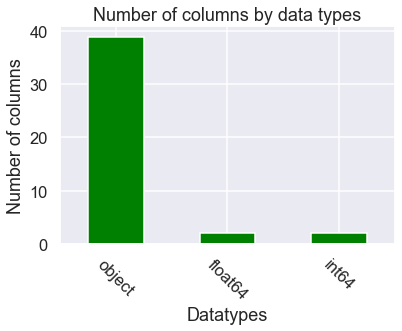

In [4]:
barplot = df.dtypes.value_counts().plot.bar(color="green");
plt.title("Number of columns by data types")
plt.xlabel("Datatypes")
plt.ylabel("Number of columns")
plt.xticks(rotation=-45)
plt.show(barplot)

In [5]:
df.describe().round()

,Speed Limit,Vehicle Year,Latitude,Longitude
count,100148.0,100148.0,100148.0,100148.0
mean,33.0,1970.0,39.0,-77.0
std,11.0,331.0,0.0,0.0
min,0.0,0.0,38.0,-79.0
25%,30.0,2004.0,39.0,-77.0
50%,35.0,2009.0,39.0,-77.0
75%,40.0,2014.0,39.0,-77.0
max,70.0,9999.0,40.0,-76.0


Further investigation of the numeric columns shows weird data. We have minimum and maximum values for *Vehicle Year* that does not make sense. Below is a distribution of all the reported vehicles with 

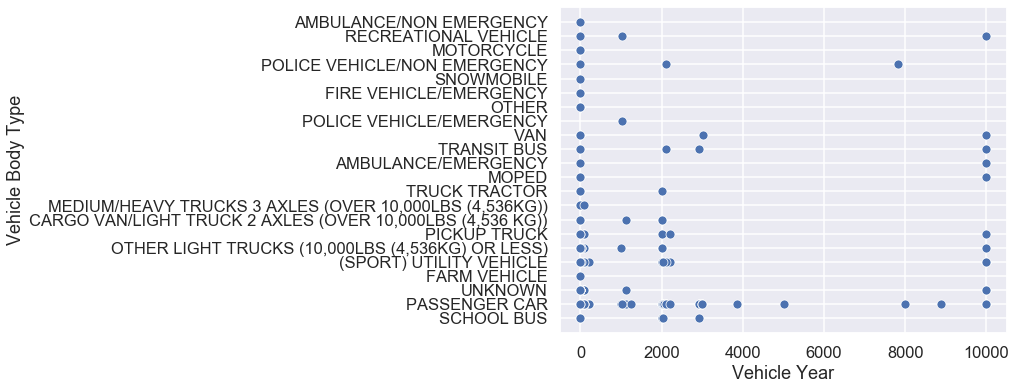

In [73]:
#df[(df["Vehicle Year"] > 2019) | (df["Vehicle Year"] < 1900)]["Vehicle Year"].value_counts().sort_index()
data = df[(df["Vehicle Year"] > 2019) | (df["Vehicle Year"] < 1900)]
sns.scatterplot(x=data["Vehicle Year"], y=data["Vehicle Body Type"]);

# Data exploration

The scatterplot above doesn't neccessarily tell too much, other than there are several vehicles registered with a model year to 0 and way above year 2020. To make this more clear, we divide the year range into three reasonable ranges, 0-1899, 1900-2020 and 2021+. When we plot this, we see that most of the reports have reasonable model years, but alot of the reports have model year 0. This is useful exploration when the data cleaning begins.

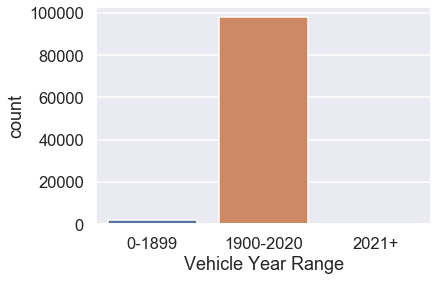

In [71]:
bins = [-1, 1899, 2020, np.inf]
names = ['0-1899', '1900-2020', '2021+']

df['Vehicle Year Range'] = pd.cut(df['Vehicle Year'], bins, labels=names)
#df.info()
#df[df["Vehicle Year Range"] == "2020+"]["Vehicle Year"].value_counts().sort_index()
data = df["Vehicle Year Range"].value_counts().sort_index()
#print(data.sum())
#print(df[(df["Vehicle Year"] >= 0) & (df["Vehicle Year"] <= 1899)].shape)
#print(df[df["Vehicle Year Range"].isna()]["Vehicle Year"])
#print(df[df["Vehicle Year Range"] == "0-1899"]["Vehicle Year")]
#df[df["Vehicle Year"] == 2020].index
sns.countplot(df["Vehicle Year Range"]);
#sns.scatterplot(data=df, hue=data)
#sns.barplot(x=df["Vehicle Year Range"], data=df)
#print(df[df["Vehicle Year Range"].isna()]["Vehicle Year"])

#print(df.dtypes.value_counts())
#df.info()
#grid = sns.FacetGrid(df["Vehicle Year Range"], row=df["Speed Limit"], col=df["Driver At Fault"])
#grid.map(plt.hist)

### Accessing specific years
## df["2015"]

#### Number of entries

Each row is represented as a 'driver'/vehicle. At first glance, it might look that each entry represents an unique accident. When doing a counting for the *Report Number* series, there is clearly several entries with same Report Number. 

In [99]:
print(df["Report Number"].value_counts().head(3))

MCP12130045    9
MCP2667000H    8
MCP3140000Y    7
Name: Report Number, dtype: int64


#### Number of entries with duplicated report numbers:

In [98]:
print(df["Report Number"].value_counts().value_counts().sort_index())

1    17309
2    33578
3     4064
4      689
5      112
6       17
7        8
8        1
9        1
Name: Report Number, dtype: int64


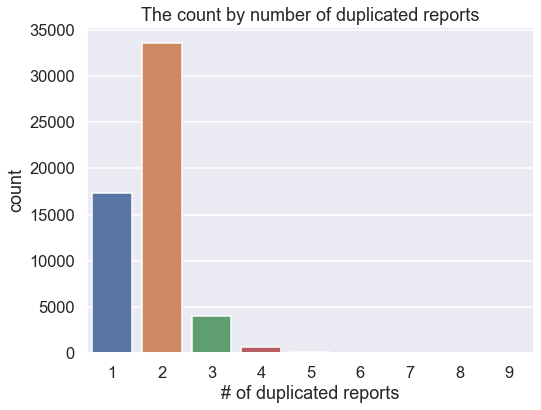

In [101]:
reports = df["Report Number"].value_counts()
reportplot = sns.countplot(reports)
plt.title("The count by number of duplicated reports")
plt.xlabel("# of duplicated reports")
plt.show(reportplot)

With further investigation of the data, we can see that there are different *Vehicle ID's* for all entries sharing same *Report Number*. With this information in mind, the plot above tells us that most of the accidents involves two vehicles. /// HER SKAL DET LAGES PLOT FOR PROSENTVIS AV ANTALL ULYKKER HVOR MANGE SOM ER INVOLVERT